# Data Preparation for Volatility Prediction

This notebook demonstrates:
1. Loading the PyTorch Geometric dataset
2. Exploring temporal graph structure
3. Analyzing feature distributions
4. Visualizing stock relationships and volatility patterns
5. Preparing train/test splits for model comparison

In [19]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from src.datasets import VNStocksDataset
from src.datasets.VNStocksDataset import VNStocksVolatilityDataset

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

## 1. Load Raw Data

First, let's load and examine the raw data files.

In [20]:
# Load raw values
values = pd.read_csv('../data/raw/values.csv').set_index(['Symbol', 'Date'])
print(f"Dataset shape: {values.shape}")
print(f"\nFeatures: {list(values.columns)}")
print(f"\nNumber of stocks: {len(values.index.get_level_values('Symbol').unique())}")
print(f"Number of trading days: {len(values.index.get_level_values('Date').unique())}")

values.head(10)

Dataset shape: (75754, 9)

Features: ['Close', 'NormClose', 'DailyLogReturn', 'ALR1W', 'ALR2W', 'ALR1M', 'ALR2M', 'RSI', 'MACD']

Number of stocks: 98
Number of trading days: 773


Close  NormClose  DailyLogReturn     ALR1W     ALR2W  \
Symbol Date                                                                    
VNM    2022-01-03   99.172217   1.564584       -0.017115  2.170026  0.011452   
       2022-01-04   97.489302   1.425703       -0.017115  2.170026  0.011452   
       2022-01-05   97.491118   1.425853        0.000019  2.170026  0.011452   
       2022-01-06  100.290336   1.656856        0.028308  2.170026  0.011452   
       2022-01-07   99.455573   1.587967       -0.008358  2.170026  0.011452   
       2022-01-10  103.535441   1.924655        0.040203  2.170026  0.011452   
       2022-01-11  104.606409   2.013036        0.010291  3.551293  0.011452   
       2022-01-12  100.823795   1.700879       -0.036830  1.694101  0.011452   
       2022-01-13  100.834133   1.701732        0.000103  0.272542  0.011452   
       2022-01-14  100.741489   1.694087       -0.000919  0.647473  0.011452   

                      ALR1M     ALR2M        RSI      MACD  
Symbol Date                                                 
VNM    2022-01-03 -0.365631 -1.034681  45.122021  0.000000  
       2022-01-04 -0.365631 -1.034681  45.122021 -0.037758  
       2022-01-05 -0.365631 -1.034681  45.122021 -0.048055  
       2022-01-06 -0.365631 -1.034681  45.122021  0.049505  
       2022-01-07 -0.365631 -1.034681  45.122021  0.068258  
       2022-01-10 -0.365631 -1.034681  45.122021  0.252705  
       2022-01-11 -0.365631 -1.034681  45.122021  0.415157  
       2022-01-12 -0.365631 -1.034681  45.122021  0.337510  
       2022-01-13 -0.365631 -1.034681  45.122021  0.279119  
       2022-01-14 -0.365631 -1.034681  45.122021  0.228865

Adjacency matrix shape: (98, 98)
Number of edges: 52
Graph density: 0.0054


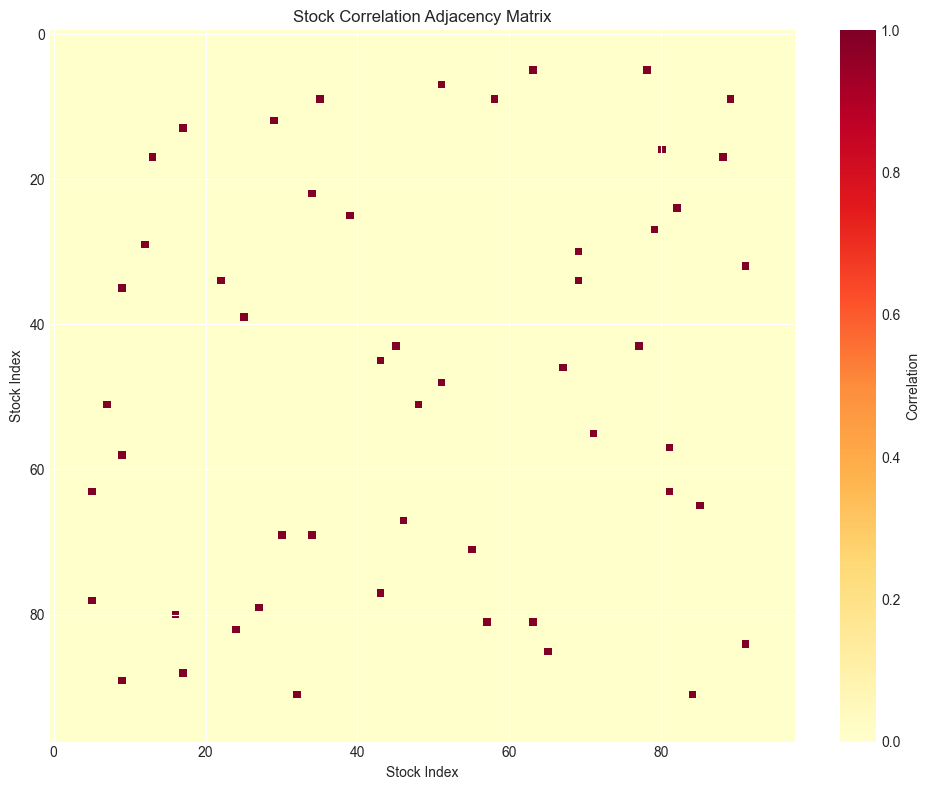

In [21]:
# Load adjacency matrix
adj = np.load('../data/raw/adj.npy')
print(f"Adjacency matrix shape: {adj.shape}")
print(f"Number of edges: {np.count_nonzero(adj)}")
print(f"Graph density: {np.count_nonzero(adj) / (adj.shape[0] * adj.shape[1]):.4f}")

# Visualize adjacency matrix
plt.figure(figsize=(10, 8))
plt.imshow(adj, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Correlation')
plt.title('Stock Correlation Adjacency Matrix')
plt.xlabel('Stock Index')
plt.ylabel('Stock Index')
plt.tight_layout()
plt.show()

## 2. Create PyTorch Geometric Dataset

Now let's create temporal graph datasets using our custom dataset classes.

In [22]:
# Create standard dataset (for price prediction baseline)
past_window = 25  # 5 weeks of trading days
future_window = 1  # Predict next day

dataset = VNStocksDataset(
    root='../data/',
    past_window=past_window,
    future_window=future_window,
    force_reload=True
)

print(f"Dataset size: {len(dataset)} temporal snapshots")
print(f"\nFirst sample:")
sample = dataset[0]
print(f"  x shape: {sample.x.shape}  # (nodes, features, timesteps)")
print(f"  y shape: {sample.y.shape}  # (nodes, future_window)")
print(f"  edge_index shape: {sample.edge_index.shape}")
print(f"  edge_weight shape: {sample.edge_weight.shape}")
print(f"  close_price shape: {sample.close_price.shape}")

sample

Processing...
Done!


Dataset size: 747 temporal snapshots

First sample:
  x shape: torch.Size([98, 8, 25])  # (nodes, features, timesteps)
  y shape: torch.Size([98, 1])  # (nodes, future_window)
  edge_index shape: torch.Size([2, 52])
  edge_weight shape: torch.Size([52])
  close_price shape: torch.Size([98, 25])


Data(x=[98, 8, 25], edge_index=[2, 52], y=[98, 1], edge_weight=[52], close_price=[98, 25], close_price_y=[98, 1])

In [23]:
# Create volatility dataset (main task)
volatility_dataset = VNStocksVolatilityDataset(
    root='../data/',
    past_window=25,
    future_window=5,  # Predict volatility over next 5 days
    volatility_window=20,  # Calculate volatility using 20-day window
    force_reload=True
)

print(f"Volatility dataset size: {len(volatility_dataset)} temporal snapshots")
print(f"\nFirst sample:")
vol_sample = volatility_dataset[0]
print(f"  x shape: {vol_sample.x.shape}")
print(f"  y shape (volatility): {vol_sample.y.shape}")
print(f"  volatility shape: {vol_sample.volatility.shape}")

vol_sample

Processing...
Done!


Volatility dataset size: 723 temporal snapshots

First sample:
  x shape: torch.Size([98, 8, 25])
  y shape (volatility): torch.Size([98, 1])
  volatility shape: torch.Size([98, 25])


Data(x=[98, 8, 25], edge_index=[2, 52], y=[98, 1], edge_weight=[52], close_price=[98, 25], close_price_y=[98, 5], volatility=[98, 25])

## 3. Feature Analysis

Analyze the distribution and statistics of features.

In [24]:
# Feature statistics
feature_names = ['NormClose', 'DailyLogReturn', 'ALR1W', 'ALR2W', 'ALR1M', 'ALR2M', 'RSI', 'MACD']

print("Feature Statistics:")
print("=" * 80)
for i, feat_name in enumerate(feature_names):
    feat_values = values.iloc[:, i+1].values  # +1 to skip 'Close'
    print(f"\n{feat_name}:")
    print(f"  Mean: {feat_values.mean():.6f}")
    print(f"  Std:  {feat_values.std():.6f}")
    print(f"  Min:  {feat_values.min():.6f}")
    print(f"  Max:  {feat_values.max():.6f}")

Feature Statistics:

NormClose:
  Mean: -0.000000
  Std:  0.999353
  Min:  -2.900064
  Max:  3.852958

DailyLogReturn:
  Mean: -0.000109
  Std:  0.020125
  Min:  -0.100423
  Max:  0.104541

ALR1W:
  Mean: -0.028272
  Std:  2.259866
  Min:  -10.163704
  Max:  10.914871

ALR2W:
  Mean: -0.025827
  Std:  1.606814
  Min:  -6.693032
  Max:  6.502227

ALR1M:
  Mean: -0.024651
  Std:  1.110324
  Min:  -4.991862
  Max:  4.482670

ALR2M:
  Mean: -0.026987
  Std:  0.786325
  Min:  -3.414233
  Max:  2.819623

RSI:
  Mean: 49.774413
  Std:  16.558591
  Min:  0.000000
  Max:  99.816575

MACD:
  Mean: 0.098893
  Std:  3.385684
  Min:  -16.827255
  Max:  34.386053


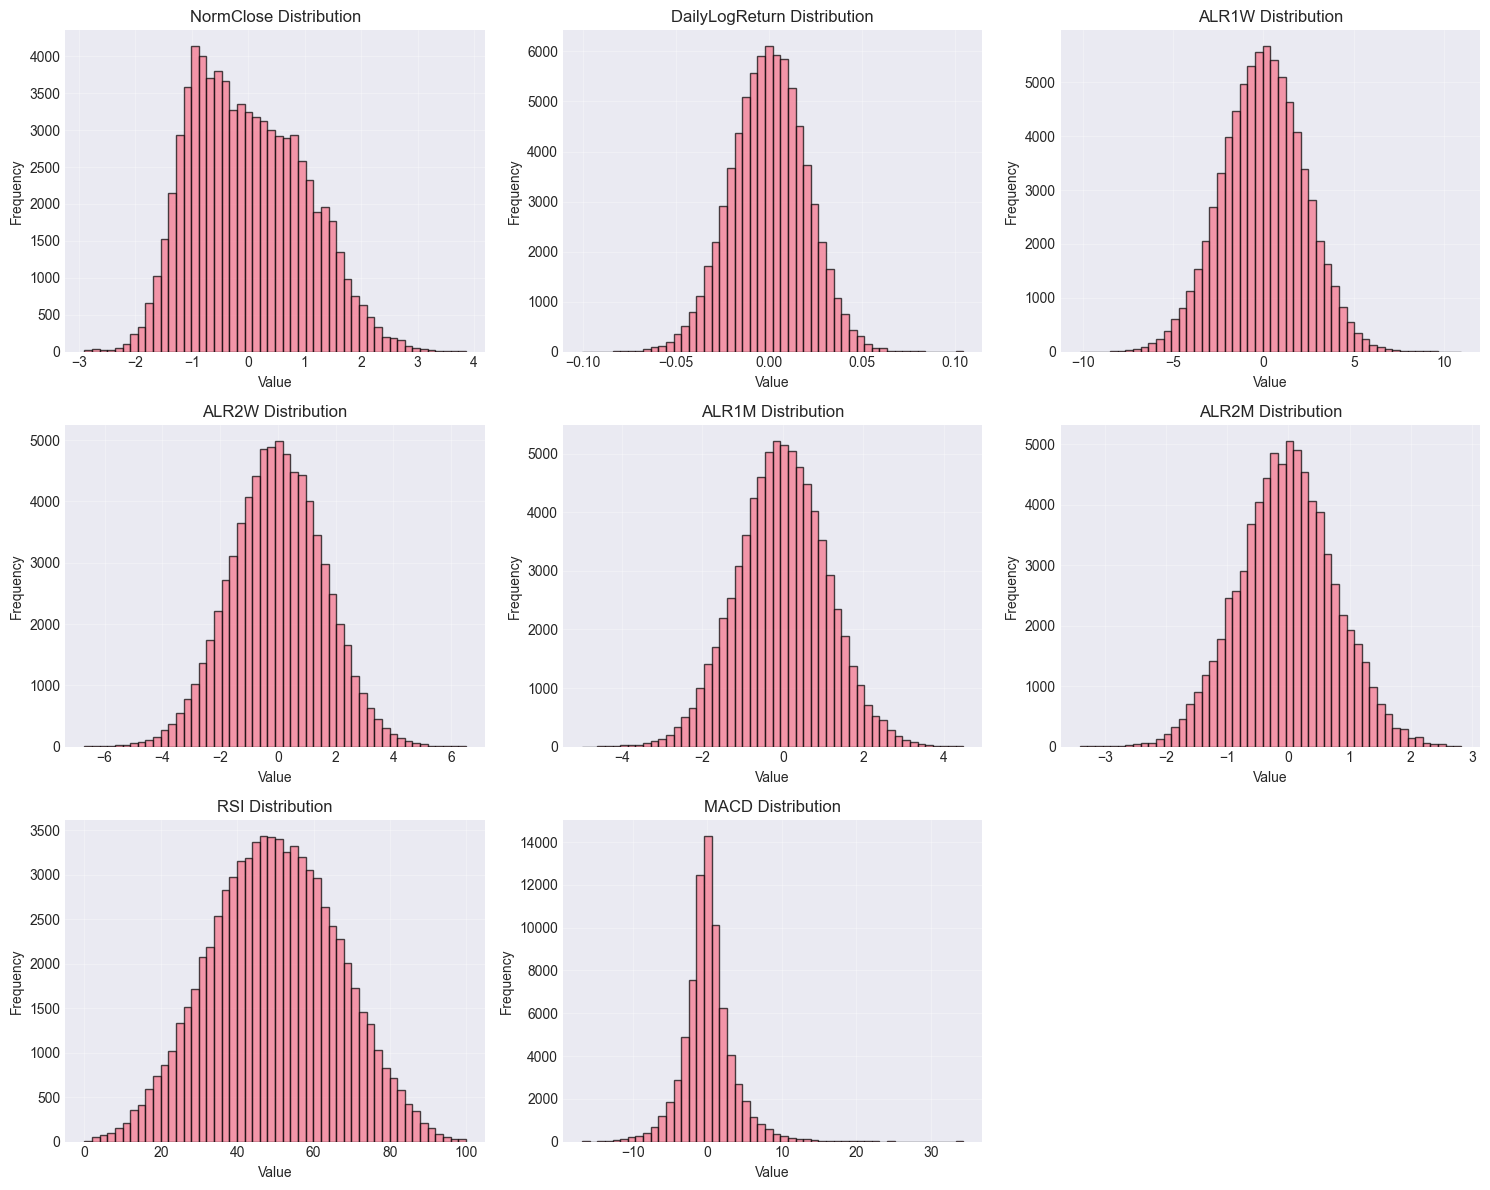

In [25]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feat_name in enumerate(feature_names):
    feat_values = values.iloc[:, i+1].values
    axes[i].hist(feat_values, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{feat_name} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

## 4. Volatility Analysis

Analyze volatility patterns in the data.

In [26]:
# Calculate volatility for all stocks
stocks = values.index.get_level_values('Symbol').unique()
volatilities = []

for stock in stocks:
    stock_data = values.loc[stock]
    returns = np.diff(np.log(stock_data['Close'].values))
    volatility = pd.Series(returns).rolling(window=20).std().values
    volatilities.append(volatility)

volatilities = np.array(volatilities)
print(f"Volatility matrix shape: {volatilities.shape}")

Volatility matrix shape: (98, 772)


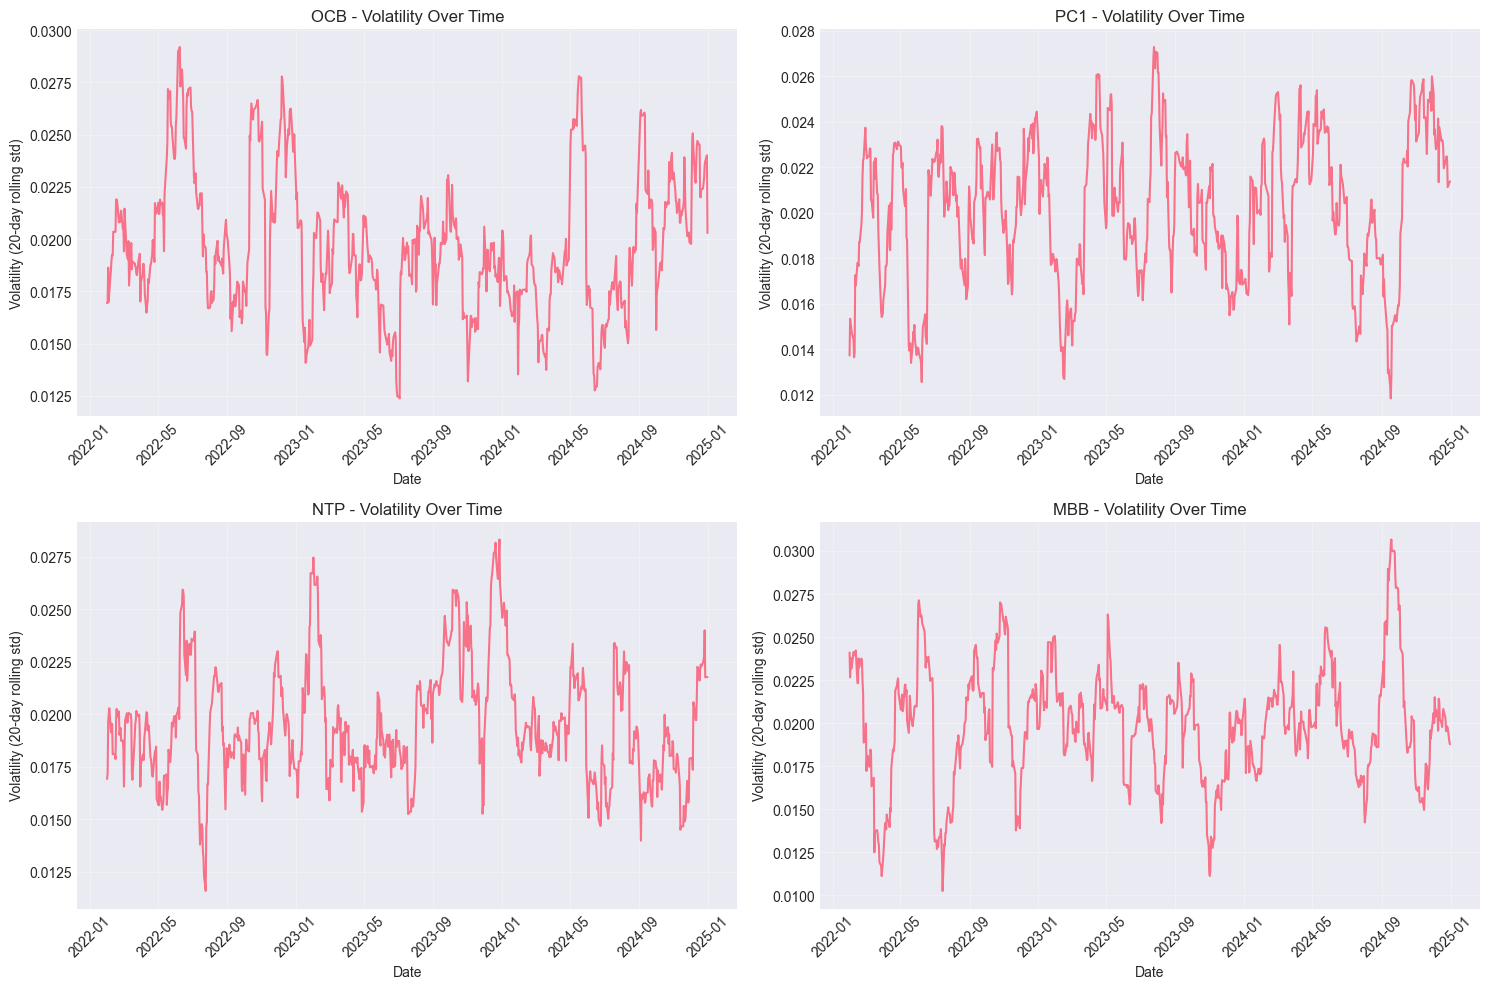

In [27]:
# Plot volatility over time for random stocks
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

np.random.seed(42)
random_stocks = np.random.choice(len(stocks), 4, replace=False)

# Get dates from first stock (all stocks have same dates)
all_dates = pd.to_datetime(values.loc[stocks[0]].index)
# Align dates with volatility (volatility is shorter due to diff and rolling)
# diff removes 1 day, so dates should start from index 1
dates = all_dates[1:]

for i, stock_idx in enumerate(random_stocks):
    axes[i].plot(dates, volatilities[stock_idx], linewidth=1.5)
    axes[i].set_title(f'{stocks[stock_idx]} - Volatility Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility (20-day rolling std)')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/var/folders/vv/j_c_gwp10_j_1j692dq0yrxr0000gp/T/ipykernel_20588/3213239679.py:2: RuntimeWarning: Mean of empty slice
  avg_volatility = np.nanmean(volatilities, axis=0)


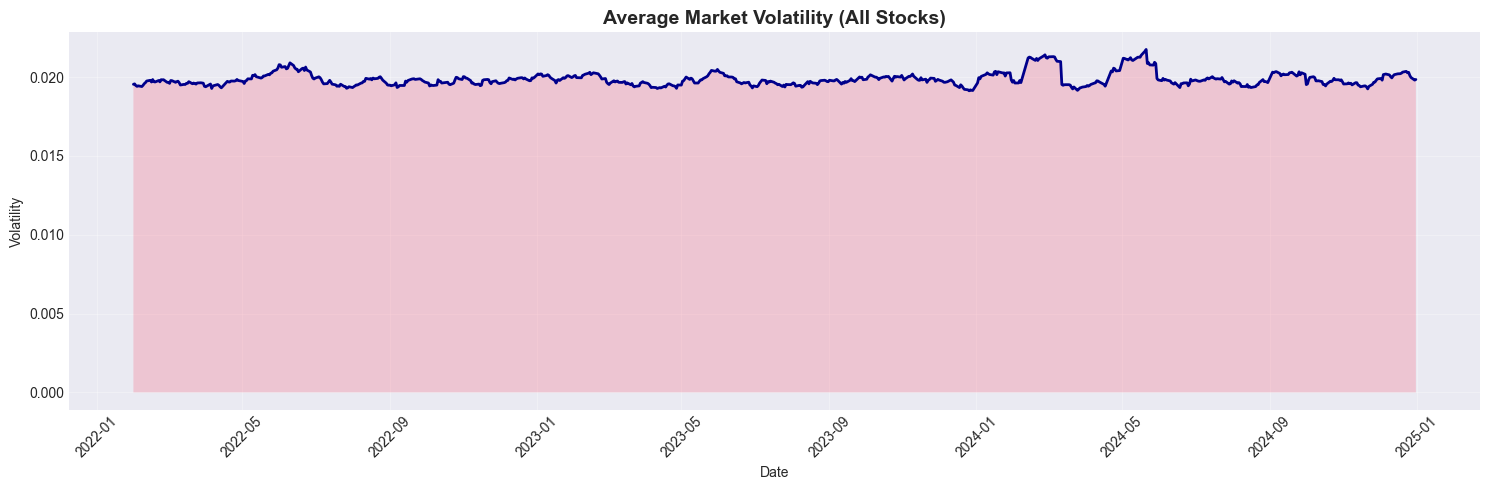


Average volatility statistics:
  Mean: 0.019863
  Std:  0.000430
  Max:  0.021752


In [28]:
# Average volatility across all stocks
avg_volatility = np.nanmean(volatilities, axis=0)

# Use dates aligned with volatility data (starting from index 1)
all_dates = pd.to_datetime(values.loc[stocks[0]].index)
dates = all_dates[1:]

plt.figure(figsize=(15, 5))
plt.plot(dates, avg_volatility, linewidth=2, color='darkblue')
plt.fill_between(dates, avg_volatility, alpha=0.3)
plt.title('Average Market Volatility (All Stocks)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nAverage volatility statistics:")
print(f"  Mean: {np.nanmean(avg_volatility):.6f}")
print(f"  Std:  {np.nanstd(avg_volatility):.6f}")
print(f"  Max:  {np.nanmax(avg_volatility):.6f}")

## 5. Graph Structure Analysis

Analyze the correlation-based graph structure.

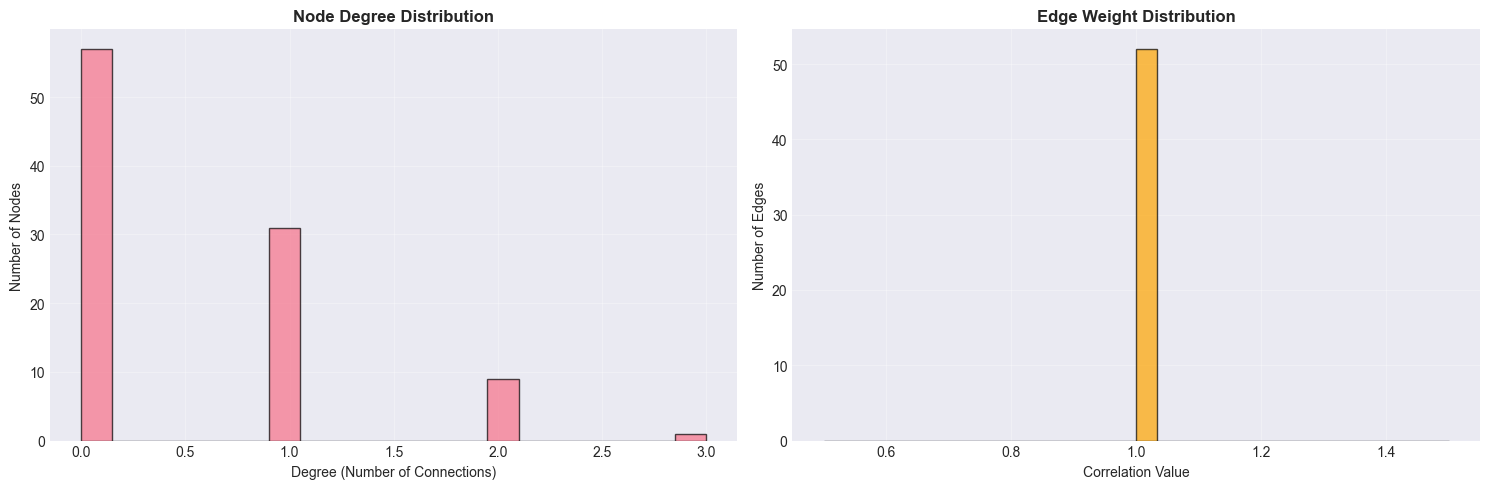

Graph statistics:
  Number of nodes: 98
  Number of edges: 52
  Average degree: 0.53
  Max degree: 3
  Average edge weight: 1.0000


In [29]:
# Degree distribution
degrees = adj.sum(axis=1) > 0  # Binary: has connections or not
out_degrees = (adj > 0).sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Degree distribution histogram
axes[0].hist(out_degrees, bins=20, alpha=0.7, edgecolor='black')
axes[0].set_title('Node Degree Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Degree (Number of Connections)')
axes[0].set_ylabel('Number of Nodes')
axes[0].grid(True, alpha=0.3)

# Edge weight distribution
edge_weights = adj[adj > 0]
axes[1].hist(edge_weights, bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Edge Weight Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Correlation Value')
axes[1].set_ylabel('Number of Edges')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Graph statistics:")
print(f"  Number of nodes: {adj.shape[0]}")
print(f"  Number of edges: {np.count_nonzero(adj)}")
print(f"  Average degree: {out_degrees.mean():.2f}")
print(f"  Max degree: {out_degrees.max()}")
print(f"  Average edge weight: {edge_weights.mean():.4f}")

## 6. Train/Test Split

Prepare data splits for model training and evaluation.

In [30]:
# Standard 80-20 train-test split for time series
train_ratio = 0.8
train_size = int(len(volatility_dataset) * train_ratio)

train_dataset = volatility_dataset[:train_size]
test_dataset = volatility_dataset[train_size:]

print(f"Dataset splits:")
print(f"  Total samples: {len(volatility_dataset)}")
print(f"  Train samples: {len(train_dataset)} ({len(train_dataset)/len(volatility_dataset)*100:.1f}%)")
print(f"  Test samples:  {len(test_dataset)} ({len(test_dataset)/len(volatility_dataset)*100:.1f}%)")

# Save split indices for reproducibility
split_info = {
    'train_size': train_size,
    'test_size': len(volatility_dataset) - train_size,
    'train_ratio': train_ratio,
    'past_window': past_window,
    'future_window': future_window
}

import json
with open('../data/train_test_split.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"\nSplit configuration saved to '../data/train_test_split.json'")

Dataset splits:
  Total samples: 723
  Train samples: 578 (79.9%)
  Test samples:  145 (20.1%)

Split configuration saved to '../data/train_test_split.json'


In [31]:
# Create DataLoaders for batch processing
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test a batch
batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  x shape: {batch.x.shape}")
print(f"  y shape: {batch.y.shape}")
print(f"  batch size: {batch.num_graphs}")

DataLoaders created:
  Batch size: 32
  Train batches: 19
  Test batches: 5

Sample batch:
  x shape: torch.Size([3136, 8, 25])
  y shape: torch.Size([3136, 1])
  batch size: 32


## 7. Summary

Data preparation is complete! We have:

### Dataset
- **98 Vietnamese FDI stocks** from 2022-01-01 to 2024-12-31
- **773 trading days** of historical data
- **9 features** per stock: Close, NormClose, DailyLogReturn, ALR1W, ALR2W, ALR1M, ALR2M, RSI, MACD

### Graph Structure
- **52 edges** based on correlation threshold (0.1)
- **Correlation-based adjacency matrix** capturing stock relationships
- **Sparse graph** with density of 0.54%

### Temporal Snapshots
- **Input window**: 25 trading days (~5 weeks)
- **Prediction window**: 5 trading days (volatility over next week)
- **Volatility calculation**: 20-day rolling standard deviation

### Splits
- **Train**: 80% of temporal snapshots
- **Test**: 20% of temporal snapshots

### Next Steps
1. Implement baseline models (ARIMA)
2. Implement ML models (Random Forest)
3. Implement DL models (LSTM, GRU)
4. Compare model performance on volatility prediction task